# Analysis of the Skytrax Review Dataset

## Import Startements

In [1]:
# import standard data analysis python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Global options and color definition

In [2]:
pd.set_option('display.max_rows', 20)

pos = '#FF7518' # pumpkin orange
neg = '#18A2FF' # complementary color

# Corporate colors for airlines from https://www.schemecolor.com/

# LH Group
lufthansaBlue = '#00235F'
swissRed = '#E60005'
austrianBlue = 'lightskyblue' #'#e71c23'

# Five-Star airlines
siaOrange = '#fcb130'
cathayGreen = '#00645a'
qatarGrey = '#747f8a'
garudaBlue = '#002561'

# US legacy carrier
unitedBlue = '#005daa'
americanGray = '#C7CFD7'
deltaBlue = '#003268'
deltaRed = '#9b1631'

# large european airlines
klmBlue = '#00a1e4'
afRed = '#002157'
britishBlue = '#0035AD'

In [3]:
# Import dataset 
data = pd.read_csv('./data/airline.csv')

# this dictionary stores the content variable for all airlines. Gets filled during data cleaning and might be useful
contentData = {}

## Data loading and data cleaning functions

In [4]:
def get_airline_data(name):
    """ data loader function to get data for a selected airline
    
    Parameters
    ----------
    name : string
        Airline name

    Returns
    -------
    airlineData : DataFrame
            Pandas DataFrame that contains data of selected airline
    """
    # use global data variable (if exists) to avoid repetitive loading of dataset
    global data
    global contentData
    
    if data is None:
        data = pd.read_csv('./data/airline.csv')
    
    airlineData = data[data["airline_name"] == name]
    airlineData = airlineData.reset_index(drop=True)
    
    contentData[name] = airlineData['content']
    
    print(f"Dataset for {name.upper()} contains {len(airlineData)} data points")
    
    return airlineData

In [5]:
def get_missing_data(data):
    """ prints out all columns that have NaN values
    
    Parameters
    ----------
    data : DataFrame
        Airline data
    """
    
    # flag to indicate whether missing values were found
    missingValues = False
    
    # iterate through all columns and count number of missing values
    for col in data.columns:
        numberMissing = data[col].isna().sum()
        missPercentage = np.around(numberMissing/len(data)*100, decimals=1)
        if numberMissing > 0 :
            missingValues = True
            print(f'{col.upper()} : ({numberMissing}/{len(data)}) missing values ({missPercentage}%) ')
    
    if not missingValues:
        print("No NaN values left!")

In [6]:
def clean_metadata(data):
    """ data loader function to get data for a selected airline
    
    Parameters
    ----------
    data : DataFrame
        Airline data

    Returns
    -------
    cleanedData : DataFrame
        data without the columns that contain metadata
    """
    
    # rename labels for First and Business Class
    data.replace(to_replace={'cabin_flown' : 'Business Class'}, value='Business', inplace=True)
    data.replace(to_replace={'cabin_flown' : 'First Class'}, value='First', inplace=True)
        
    # rename Airline column
    data.rename(columns={'airline_name' : 'Airline'}, inplace=True)
    
    # drop metadata columns
    cleanedData = data.drop(columns={"link", "author", "author_country", "title", 
                                     "aircraft", "route", "content", "type_traveller"})
    return cleanedData

In [7]:
def remove_nan(data, threshold=0):
    """ data loader function to get data for a selected airline
    
    Parameters
    ----------
    data : DataFrame
        Airline data
    
    threshold : int
        If the number of NaN values in a column is below this threshold, the respective rows are dropped
        to remove the NaN values
    
    Returns
    -------
    cleanedData : DataFrame
        data cleaned from NaN values 
    """
    
    data = data.drop(columns={"wifi_connectivity_rating", "ground_service_rating"})
   
    # replace value for inflight entertainemnt with mean
    data['inflight_entertainment_rating'].fillna(
    value=np.around(data['inflight_entertainment_rating'].mean()), inplace=True)
    
    # replace value for missing overall rating by mean of all other ratings
    ratingNaNIndex = data[data['overall_rating'].isna()==True].index
      
    for index in ratingNaNIndex:
        replaceValue = data[['seat_comfort_rating','cabin_staff_rating','food_beverages_rating',
                              'inflight_entertainment_rating','value_money_rating']].iloc[index].mean()
        data.loc[index,'overall_rating'] = max(np.around(replaceValue),1)
    
    # drop NaN below 
    for col in data.columns:
        numberMissing = data[col].isna().sum()
        #print(f"{col} : {numberMissing} values")
        
        if numberMissing <= threshold:
            data = data[data[col].notna()]
            
    return data  

# Data Analysis

This Jupyter notebook contains an analysis of the Skytrax customer review dataset (Link: https://github.com/quankiquanki/skytrax-reviews-dataset). The main focus is to investigate the customer reviews of SWISS International Airlines and compare them to other airlines. 

# Analysiere Kundenbewertungen der Swiss im Zeitraum von 2012 bis 2015

In den Jahren 2012 - 2015 betrug die jährliche Zahl der Fluggäste etwa  17 Mio. (Quelle: https://de.statista.com/statistik/daten/studie/291651/umfrage/fluggaeste-von-swiss/)

## Load data

In [8]:
# get data for LH-Group airlines

swiss = get_airline_data("swiss-international-air-lines")
lufthansa = get_airline_data("lufthansa")
austrian = get_airline_data("austrian-airlines")

# get data for all Airlines that were rated with 5 Stars in 2015 by Skytrax
# source: https://en.wikipedia.org/wiki/Skytrax#Airline_rankings
    
sia = get_airline_data("singapore-airlines")
ana = get_airline_data("ana-all-nippon-airways")
qatar = get_airline_data("qatar-airways")
cathay = get_airline_data("cathay-pacific-airways")
asiana = get_airline_data("asiana-airlines")
eva = get_airline_data("eva-air")
garuda = get_airline_data("garuda-indonesia")
hainan = get_airline_data("hainan-airlines")
jal = get_airline_data("japan-airlines")
korean = get_airline_data("korean-air")

# get data for US legacy carriers 
american = get_airline_data("american-airlines")
united = get_airline_data("united-airlines")
delta = get_airline_data("delta-air-lines")

# get data for other major european airlines
airfrance = get_airline_data("air-france")
british = get_airline_data("british-airways")
klm = get_airline_data("klm-royal-dutch-airlines")

# store all airline dataset into dictionary
lhGroup = {'swiss' : swiss, 'lufthansa': lufthansa, 'austrian' : austrian}

fiveStar = {'sia' : sia, 'ana' : ana, 'qatar' : qatar, 'cathay' : cathay, 'asiana' : asiana,
            'eva' : eva, 'garuda' : garuda, 'hainan' : hainan, 'jal' : jal, 'korean' : korean}

legacyCarrier = {'united' : united, 'delta' : delta, 'american' : american}

europe = {'airfrance' : airfrance, 'british' : british, 'klm' : klm}

Dataset for SWISS-INTERNATIONAL-AIR-LINES contains 336 data points
Dataset for LUFTHANSA contains 600 data points
Dataset for AUSTRIAN-AIRLINES contains 281 data points
Dataset for SINGAPORE-AIRLINES contains 432 data points
Dataset for ANA-ALL-NIPPON-AIRWAYS contains 273 data points
Dataset for QATAR-AIRWAYS contains 492 data points
Dataset for CATHAY-PACIFIC-AIRWAYS contains 494 data points
Dataset for ASIANA-AIRLINES contains 303 data points
Dataset for EVA-AIR contains 302 data points
Dataset for GARUDA-INDONESIA contains 352 data points
Dataset for HAINAN-AIRLINES contains 88 data points
Dataset for JAPAN-AIRLINES contains 171 data points
Dataset for KOREAN-AIR contains 322 data points
Dataset for AMERICAN-AIRLINES contains 612 data points
Dataset for UNITED-AIRLINES contains 840 data points
Dataset for DELTA-AIR-LINES contains 466 data points
Dataset for AIR-FRANCE contains 398 data points
Dataset for BRITISH-AIRWAYS contains 901 data points
Dataset for KLM-ROYAL-DUTCH-AIRLINES c

## Preprocessing

### Data Cleaning

Zuerst werden alle Spalten entfernt, die keinen (unmittelbaren) Einfluss auf die Bewertung des Fluggastes haben (Metadaten):
* **link**: Link zur Datenquelle (irrelevant) -> **drop**
* **author & author_country**: Name und Herkunft des Autors (irrelevant) -> **drop**
* **airline_name**: Für alle Datenpunkte gleich, da nur Swiss betrachtet wird -> **drop**  **Überprüfen**
* **title**: Auch für alle Datenpunkte gleich -> **drop** 

Folgende Variablen können einen Einfluss auf die Zufriedenheit der Kunden haben 
* **aircraft**: Leider nur für 14 der 336 Datenpunkte erfasst, der Flugzeugtyp kann aber prinzipiell die Kundenzufriedenheit beeinflussen (Beispiel A380 wird von Fluggästen sehr positiv wahrgenommen) -> Flugzeugtyp könnte aber aus anderen Datenquellen ergänzt werden, wenn Flugnummer und/oder Flugsegmente bekannt sind (FlighRadar24, interne Datenbank) -> hier aber **drop**
* **route**: Auch hier nur vereinzelt Daten vorhanden, viele Passagiere bewerten ihre gesamte Reise, die oft auch aus mehreren Flugsegmenten besteht. Route könnte bei Bedarf teilweise aus **content** abgeleitet werden. Für diesen vereinfachten Fall wird das gesamte Reiseerlebnis mit Swiss betrachtet, unabhängig von Route und möglichen Umstiegen -> **drop**
* **content**: Geschriebene Bewertung der Nutzer und ist für alle Datenpunkte vorhanden. Enthält sehr viele Infos zu Route, Aircraft und allgemeinenen Zufriedenheit, die durch Natural Language Processing (NLP) extrahiert werden könnten. **Sehr wertvolle Daten, bei denen sich grundsätzlich eine weiterführende Analyse anbietet** -> werden in der Variable **contentData** abgespeichert 
* **type traveller**: Geschäftsreisende haben andere (oft höhere) Ansprüche an das Produkt, als Privatreisende. Allerdings sind auch hier nur unzureichende Daten vorhanden -> **drop**

In [9]:
# apply functions to remove metadata and NaN values to LH-Group airlines
for key, value in lhGroup.items():
    cleaned = clean_metadata(value)
    lhGroup[key] = remove_nan(cleaned, 4)

In [10]:
# apply functions to remove metadata and NaN values to 5-Star airlines
for key, value in fiveStar.items():
    cleaned = clean_metadata(value)
    fiveStar[key] = remove_nan(cleaned, 1)

In [11]:
# apply functions to remove metadata and NaN values to legacy carriers
for key, value in legacyCarrier.items():
    cleaned = clean_metadata(value)
    legacyCarrier[key] = remove_nan(cleaned, 19)

In [12]:
# apply functions to remove metadata and NaN values of european airlines
for key, value in europe.items():
    cleaned = clean_metadata(value)
    europe[key] = remove_nan(cleaned, 5)

In [13]:
for key, value in lhGroup.items():
    print(f'{key.upper()} - {len(value)} reviews\n')
    get_missing_data(value)
    print("\n")

SWISS - 336 reviews

No NaN values left!


LUFTHANSA - 600 reviews

No NaN values left!


AUSTRIAN - 277 reviews

No NaN values left!




In [14]:
for key, value in fiveStar.items():
    print(f'{key.upper()} - {len(value)} reviews\n')
    get_missing_data(value)
    print("\n")

SIA - 432 reviews

No NaN values left!


ANA - 273 reviews

SEAT_COMFORT_RATING : (99/273) missing values (36.3%) 
CABIN_STAFF_RATING : (99/273) missing values (36.3%) 
FOOD_BEVERAGES_RATING : (99/273) missing values (36.3%) 


QATAR - 492 reviews

No NaN values left!


CATHAY - 492 reviews

No NaN values left!


ASIANA - 303 reviews

SEAT_COMFORT_RATING : (52/303) missing values (17.2%) 
CABIN_STAFF_RATING : (52/303) missing values (17.2%) 
FOOD_BEVERAGES_RATING : (52/303) missing values (17.2%) 


EVA - 302 reviews

SEAT_COMFORT_RATING : (56/302) missing values (18.5%) 
CABIN_STAFF_RATING : (56/302) missing values (18.5%) 
FOOD_BEVERAGES_RATING : (56/302) missing values (18.5%) 


GARUDA - 352 reviews

No NaN values left!


HAINAN - 88 reviews

SEAT_COMFORT_RATING : (39/88) missing values (44.3%) 
CABIN_STAFF_RATING : (39/88) missing values (44.3%) 
FOOD_BEVERAGES_RATING : (39/88) missing values (44.3%) 


JAL - 171 reviews

SEAT_COMFORT_RATING : (55/171) missing values (32.2%) 
CABI

In [15]:
for key, value in legacyCarrier.items():
    print(f'{key.upper()} - {len(value)} reviews\n')
    get_missing_data(value)
    print("\n")

UNITED - 820 reviews

No NaN values left!


DELTA - 458 reviews

No NaN values left!


AMERICAN - 598 reviews

No NaN values left!




In [16]:
for key, value in europe.items():
    print(f'{key.upper()} - {len(value)} reviews\n')
    get_missing_data(value)
    print("\n")

AIRFRANCE - 397 reviews

No NaN values left!


BRITISH - 894 reviews

No NaN values left!


KLM - 370 reviews

No NaN values left!




## Preprocessing

### Data Cleaning

Zuerst werden alle Spalten entfernt, die keinen (unmittelbaren) Einfluss auf die Bewertung des Fluggastes haben (Metadaten):
* **link**: Link zur Datenquelle (irrelevant) -> **drop**
* **author & author_country**: Name und Herkunft des Autors (irrelevant) -> **drop**
* **airline_name**: Für alle Datenpunkte gleich, da nur Swiss betrachtet wird -> **drop**  **Überprüfen**
* **title**: Auch für alle Datenpunkte gleich -> **drop** 
* **date**: Saisonale Effekte und zeitliche Veränderungen sollen vernachlässigt werden -> **drop** **Nicht unbedingt**

Folgende Variablen können einen Einfluss auf die Zufriedenheit der Kunden haben 
* **aircraft**: Leider nur für 14 der 336 Datenpunkte erfasst, der Flugzeugtyp kann aber prinzipiell die Kundenzufriedenheit beeinflussen (Beispiel A380 wird von Fluggästen sehr positiv wahrgenommen) -> Flugzeugtyp könnte aber aus anderen Datenquellen ergänzt werden, wenn Flugnummer und/oder Flugsegmente bekannt sind (FlighRadar24, interne Datenbank) -> hier aber **drop**
* **route**: Auch hier nur vereinzelt Daten vorhanden, viele Passagiere bewerten ihre gesamte Reise, die oft auch aus mehreren Flugsegmenten besteht. Route könnte bei Bedarf teilweise aus **content** abgeleitet werden. Für diesen vereinfachten Fall wird das gesamte Reiseerlebnis mit Swiss betrachtet, unabhängig von Route und möglichen Umstiegen -> **drop**
* **content**: Geschriebene Bewertung der Nutzer und ist für alle Datenpunkte vorhanden. Enthält sehr viele Infos zu Route, Aircraft und allgemeinenen Zufriedenheit, die durch Natural Language Processing (NLP) extrahiert werden könnten. **Sehr wertvolle Daten, bei denen sich grundsätzlich eine weiterführende Analyse anbietet** -> werden in der Variable **writtenReview** abgespeichert 
* **type traveller**: Geschäftsreisende haben andere (oft höhere) Ansprüche an das Produkt, als Privatreisende. Allerdings sind auch hier nur unzureichende Daten vorhanden -> **drop**

In [17]:
#writtenReview = swiss['content']
#swiss = swiss.drop(columns={"link", "author", "author_country", "airline_name", "title", 
#                             "date", "aircraft", "route", "content", "type_traveller"})
#swiss = clean_metadata(swiss)
#swiss = airlines['swiss']

Somit bleiben folgende Variablen übrig, die einen direkten Einfluss auf die Kundenzufriedenheit haben:
* **cabin_flown**
* **overall_rating**
* **seat_comfort_rating**
* **cabin_staff_rating**
* **food_beverages_rating**
* **inflight_entertainment_rating**
* **ground_service_rating**
* **wifi_connectivity_rating**
* **value_money_rating**
* **recommended**

### Fehlende Werte
Im nächsten Schritt wird ermittelt, wie viele fehlende Werte es pro Merkmal gibt und danach eine Strategie entwickelt diese zu ersetzen

In [18]:
#get_missing_data(airlines['swiss'])

Die Merkmale **ground_service_rating** und **wifi_connectivity_rating** fehlen bei fast allen Bewertungen. Nachfolgend wird angenommen, dass der Ground Service im Vergleich zu den direkt mit dem Flug verbundenen Kriterien wie Sitz, Flugpersonal, Essen- und Trinken, etc. eine untergeordnete Rolle spiel und vernachlässigt werden kann. Da Internet an Bord erst mit der 777-300ER im Jahr 2016 flächendeckend bei Swiss eingeführt wurde (Quelle: https://www.swiss.com/corporate/DE/medien/newsroom/medienmitteilungen/media-release-20160127), wird dieses Merkmal ebenfalls vernachlässigt  

In [19]:
# Create data set and color palette for LH-group

groupPalette = {'Lufthansa' : lufthansaBlue, 'Swiss' : swissRed, 'Austrian' : austrianBlue}

groupSet = pd.concat([lhGroup['swiss'], lhGroup['lufthansa'], lhGroup['austrian']])
groupSet.replace(to_replace={'Airline' : 'swiss-international-air-lines'}, value='Swiss', inplace=True)
groupSet.replace(to_replace={'Airline' : 'austrian-airlines'}, value='Austrian', inplace=True)
groupSet.replace(to_replace={'Airline' : 'lufthansa'}, value='Lufthansa', inplace=True)

# Create data set and color palette for 5-Star airlines

fiveStarPalette = {'Swiss' : swissRed, 'Singapore' : siaOrange,
                   'Cathay' : cathayGreen, 'Qatar' : qatarGrey, 'Garuda' : garudaBlue}

fiveStarSet = pd.concat([lhGroup['swiss'], fiveStar['sia'],
                     fiveStar['cathay'], fiveStar['qatar'], fiveStar['garuda']])

fiveStarSet.replace(to_replace={'Airline' : 'singapore-airlines'}, value='Singapore', inplace=True)
fiveStarSet.replace(to_replace={'Airline' : 'cathay-pacific-airways'}, value='Cathay', inplace=True)
fiveStarSet.replace(to_replace={'Airline' : 'qatar-airways'}, value='Qatar', inplace=True)
fiveStarSet.replace(to_replace={'Airline' : 'swiss-international-air-lines'}, value='Swiss', inplace=True)
fiveStarSet.replace(to_replace={'Airline' : 'garuda-indonesia'}, value='Garuda', inplace=True)

# Create data set and color palette for 5-Star airlines

legacyPalette = {'Swiss' : swissRed, 'American' : americanGray, 'United' : unitedBlue, 'Delta' : deltaBlue}

legacySet = pd.concat([lhGroup['swiss'], legacyCarrier['united'],
                     legacyCarrier['delta'], legacyCarrier['american']])

legacySet.replace(to_replace={'Airline' : 'united-airlines'}, value='United', inplace=True)
legacySet.replace(to_replace={'Airline' : 'delta-air-lines'}, value='Delta', inplace=True)
legacySet.replace(to_replace={'Airline' : 'american-airlines'}, value='American', inplace=True)
legacySet.replace(to_replace={'Airline' : 'swiss-international-air-lines'}, value='Swiss', inplace=True)

# Create data set and color palette for european competitors

europePalette = {'Swiss' : swissRed, 'AirFrance' : afRed, 'KLM' : klmBlue, 'British' : britishBlue}

europeSet = pd.concat([lhGroup['swiss'], europe['airfrance'],
                     europe['klm'], europe['british']])

europeSet.replace(to_replace={'Airline' : 'klm-royal-dutch-airlines'}, value='KLM', inplace=True)
europeSet.replace(to_replace={'Airline' : 'air-france'}, value='AirFrance', inplace=True)
europeSet.replace(to_replace={'Airline' : 'british-airways'}, value='British', inplace=True)
europeSet.replace(to_replace={'Airline' : 'swiss-international-air-lines'}, value='Swiss', inplace=True)

In [20]:
# drop columns for ground_service_rating and wifi_connectivity_rating
#swiss = swiss.drop(columns={"wifi_connectivity_rating", "ground_service_rating"})

In [21]:
# show remaining columns with missing values
for col in swiss.columns:
    numberMissing = swiss[col].isna().sum()
    if numberMissing > 0 :
        print(f'Variable : {col} : {numberMissing} missing values')

Variable : aircraft : 322 missing values
Variable : type_traveller : 318 missing values
Variable : route : 318 missing values
Variable : overall_rating : 18 missing values
Variable : inflight_entertainment_rating : 3 missing values
Variable : ground_service_rating : 321 missing values
Variable : wifi_connectivity_rating : 333 missing values


In [22]:
# get indices for rows with missing overall rating
ifeNaNIndex = swiss[swiss['inflight_entertainment_rating'].isna()==True].index

# show rows with NaN for inflight entertainment before replacement
swiss.loc[ifeNaNIndex]

,Airline,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
1,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,Marc Vermeire,Belgium,2015-07-27,Brussels to Barcelona via Zurich. Brussels - Z...,NaN,Solo Leisure,Business,Brussels to Barcelona via Zurich,9.0,4.0,5.0,5.0,NaN,5.0,NaN,5.0,1
3,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,J Tung,United Kingdom,2015-07-23,Malta to London City via Zurich. The first lag...,A320/E190,Couple Leisure,Economy,Malta to LCY via Zurich,7.0,4.0,4.0,4.0,NaN,3.0,NaN,4.0,1
15,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,Farine Ludovic,Switzerland,2015-06-13,GVA-LHR-GVA with family. Both flights were the...,NaN,Solo Leisure,Economy,GVA-LHR-GVA,10.0,5.0,5.0,4.0,NaN,NaN,NaN,5.0,1


In [23]:
# Replace missing values for inflight entertainment with mean
swiss['inflight_entertainment_rating'].fillna(
    value=np.around(swiss['inflight_entertainment_rating'].mean()), inplace=True)

# show rows with replaced values
swiss.loc[ifeNaNIndex]

,Airline,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
1,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,Marc Vermeire,Belgium,2015-07-27,Brussels to Barcelona via Zurich. Brussels - Z...,NaN,Solo Leisure,Business,Brussels to Barcelona via Zurich,9.0,4.0,5.0,5.0,3.0,5.0,NaN,5.0,1
3,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,J Tung,United Kingdom,2015-07-23,Malta to London City via Zurich. The first lag...,A320/E190,Couple Leisure,Economy,Malta to LCY via Zurich,7.0,4.0,4.0,4.0,3.0,3.0,NaN,4.0,1
15,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,Farine Ludovic,Switzerland,2015-06-13,GVA-LHR-GVA with family. Both flights were the...,NaN,Solo Leisure,Economy,GVA-LHR-GVA,10.0,5.0,5.0,4.0,3.0,NaN,NaN,5.0,1


In [24]:
# get indices for rows with missing overall rating
ratingNaNIndex = swiss[swiss['overall_rating'].isna()==True].index

# show rows with NaN for overall_rating
swiss.loc[ratingNaNIndex]

,Airline,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
66,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,M Lingg,Liechtenstein,2014-10-28,I've booked a J class ticket with LX from ZRH-...,NaN,NaN,Business,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,1.0,0
89,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,R Robinson,United Kingdom,2014-08-20,We paid for 3 seats in Business Class and I ca...,NaN,NaN,Business,NaN,NaN,2.0,1.0,3.0,2.0,NaN,NaN,1.0,0
92,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,Edmond Mitraj,United Arab Emirates,2014-08-03,26th June my colleague and I were flying from ...,NaN,NaN,Economy,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,1.0,0
95,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,Y Wata,Japan,2014-07-29,July 24 Geneva-London (City). Breaking system ...,NaN,NaN,Economy,NaN,NaN,3.0,2.0,2.0,1.0,NaN,NaN,1.0,0
101,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,D Wayne,United States,2014-07-17,ZRH-NCE 08.55am departure 28 June 2014. Select...,NaN,NaN,Economy,NaN,NaN,2.0,1.0,1.0,1.0,NaN,NaN,1.0,0
104,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,Benjamin Jilek,United States,2014-07-08,My wife and I booked a flight on the Edelweiss...,NaN,NaN,Economy,NaN,NaN,2.0,1.0,1.0,4.0,NaN,NaN,2.0,0
141,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,T Nielsen,Switzerland,2014-02-07,Copenhagen to Hong Kong via Zurich. Flight out...,NaN,NaN,Economy,NaN,NaN,3.0,1.0,3.0,3.0,NaN,NaN,2.0,0
166,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,Craig Cunningham,United Kingdom,2013-12-13,Flew from London City to Sao Paulo via Zurich ...,NaN,NaN,Business,NaN,NaN,3.0,1.0,1.0,1.0,NaN,NaN,1.0,0
167,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,C Röthlisberger,Switzerland,2013-12-12,SIN-ZRH with my husband and two small children...,NaN,NaN,Economy,NaN,NaN,3.0,1.0,1.0,2.0,NaN,NaN,3.0,0
172,swiss-international-air-lines,/airline-reviews/swiss-international-air-lines,Swiss Intl Air Lines customer review,Michele Borgarelli,United States,2013-11-22,I travel about 100000 miles per year. This was...,NaN,NaN,Economy,NaN,NaN,4.0,1.0,4.0,0.0,NaN,NaN,1.0,0


In [25]:
# replace NaNs for overall rating with mean of all other ratings
#for index in ratingNaNIndex:
#    replaceValue = swiss[['seat_comfort_rating','cabin_staff_rating','food_beverages_rating',
#                          'inflight_entertainment_rating','value_money_rating']].iloc[index].mean()
#    swiss.loc[index,'overall_rating'] = max(np.around(replaceValue),1)

# show replaced values
#swiss.loc[ratingNaNIndex]

In [26]:
assert lhGroup['swiss'].isna().sum().sum() == 0, "There are still NaN values in dataset"

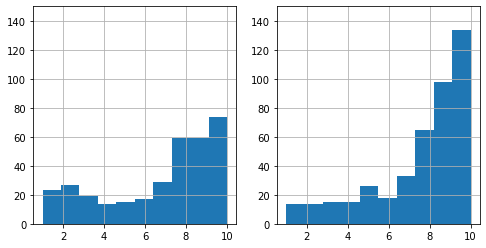

In [27]:
figRate, axRate = plt.subplots(1,2, figsize=(8,4))
lhGroup['swiss']['overall_rating'].hist(ax=axRate[0])
fiveStar['sia']['overall_rating'].hist(ax=axRate[1])

for i in range(2):
    axRate[i].set_ylim(0, 150)

## Zeitlicher Verlauf

* **date**: Saisonale Effekte und zeitliche Veränderungen sollen vernachlässigt werden -> **drop** **Nicht unbedingt**

In [28]:
airline1 = fiveStar['asiana']
airline2 = lhGroup['swiss']

<AxesSubplot:xlabel='cabin_flown'>

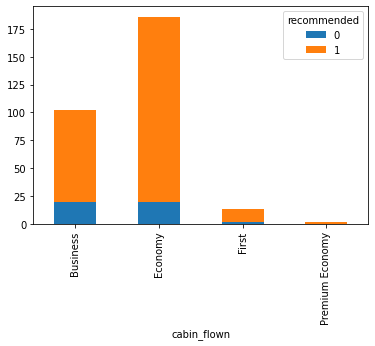

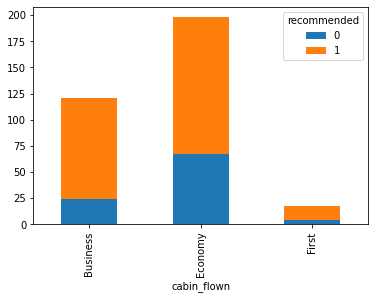

In [29]:
pd.crosstab(airline1['cabin_flown'],airline1['recommended'], normalize=False).plot.bar(stacked=True)
pd.crosstab(airline2['cabin_flown'],airline2['recommended'], normalize=False).plot.bar(stacked=True)
# Wie viel Prozent der Reisenden empfehlen Produkt weiter?

<AxesSubplot:xlabel='cabin_flown', ylabel='count'>

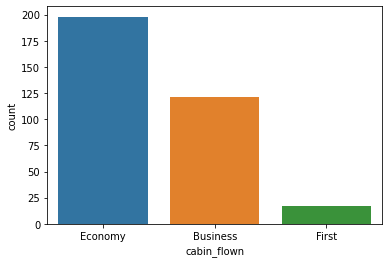

In [30]:
sns.countplot(x=airline2['cabin_flown'])

## Analyse development of reviews over time

In [31]:
#
groupSet['date'] = pd.to_datetime(groupSet['date'])
groupSet['date'] = groupSet['date'].dt.strftime('%Y-%m')
reviewTimeline = groupSet.copy(deep=True)

In [32]:
test = reviewTimeline[reviewTimeline['Airline']=='Swiss']
test[test['date']=='2014-12']

,Airline,date,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,value_money_rating,recommended
50,Swiss,2014-12,Economy,2.0,1.0,2.0,1.0,1.0,3.0,0


In [33]:
#test = reviewTimeline[reviewTimeline['Airline']=='Austrian']
#test[test['date']=='2015-04']

* Ausreisser ziehen Durchschnitt nach unten

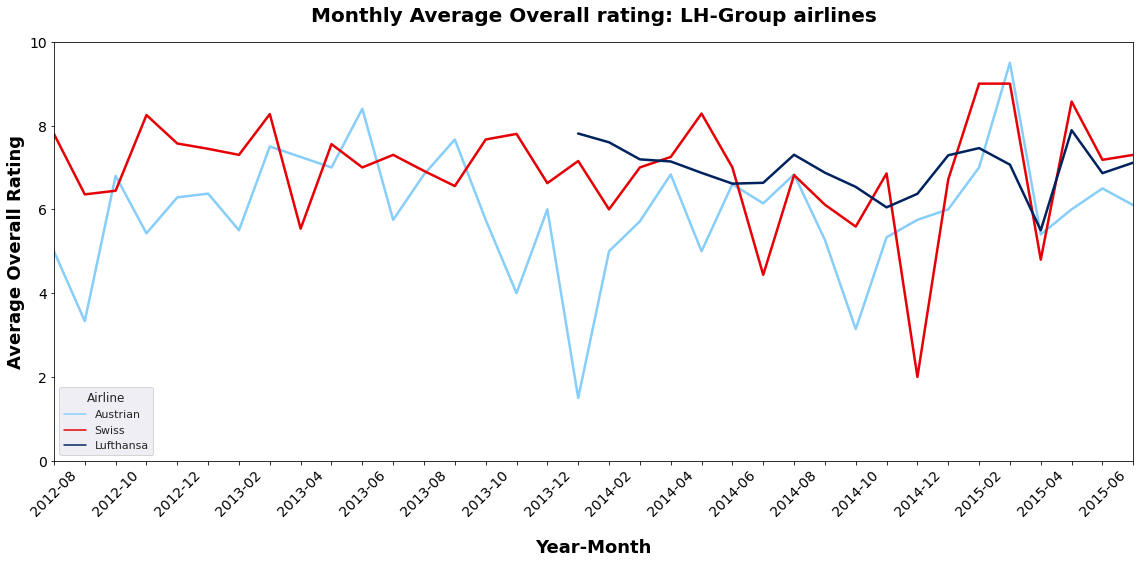

In [34]:
timeFig, timeAx = plt.subplots(1,1, figsize=(16,8))


overallMean = reviewTimeline.groupby(['date', 'Airline']).mean()
overallMean = overallMean.loc['2012-06':'2015-07']

sns.set_theme(style="darkgrid")

timeAx = sns.lineplot(x="date", y="overall_rating", hue="Airline", palette=groupPalette, data=overallMean, lw=2.5)

xticks = overallMean.index.get_level_values(0)

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

date_form = DateFormatter('%Y-%M')
timeAx.tick_params(axis='x', rotation=45)


timeAx.set_xlabel('Year-Month', fontsize=18, fontweight='bold', labelpad=20)
timeAx.set_ylabel('Average Overall Rating', fontsize=18, fontweight='bold')
timeAx.set_title('Monthly Average Overall rating: LH-Group airlines',fontsize=20, fontweight='bold', pad=20)

timeAx.tick_params(axis='both', which='major', labelsize=14)

timeAx.set_xlim(xticks[2],xticks[-1])
timeAx.set_ylim(0, 10)

# kann man über Locator und Formatter schöner lösen, aber tut hier seinen Zweck
for index, label in enumerate(timeAx.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
timeFig.tight_layout()

## Da Ausreisser den Mittelwert stark beeinflussen, soll der gleitende Durchschnitt über mehrere Monate berechenet werden

In [35]:
test = reviewTimeline[reviewTimeline['Airline']=='Austrian']
test[test['date']=='2011-11'].mean()

/tmp/ipykernel_10109/2799124419.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test[test['date']=='2011-11'].mean()


overall_rating                   6.833333
seat_comfort_rating              2.833333
cabin_staff_rating               4.166667
food_beverages_rating            4.000000
inflight_entertainment_rating    2.833333
value_money_rating               3.500000
recommended                      0.833333
dtype: float64

In [36]:
monthlyMean = reviewTimeline.drop(columns={'cabin_flown'})
monthlyMean = monthlyMean.groupby(['Airline','date']).mean()
monthlyMean = monthlyMean.reset_index()
rollingMean = monthlyMean.groupby(['Airline']).rolling(3,1, on='date').mean()

In [37]:
xticks[0]

'2012-06'

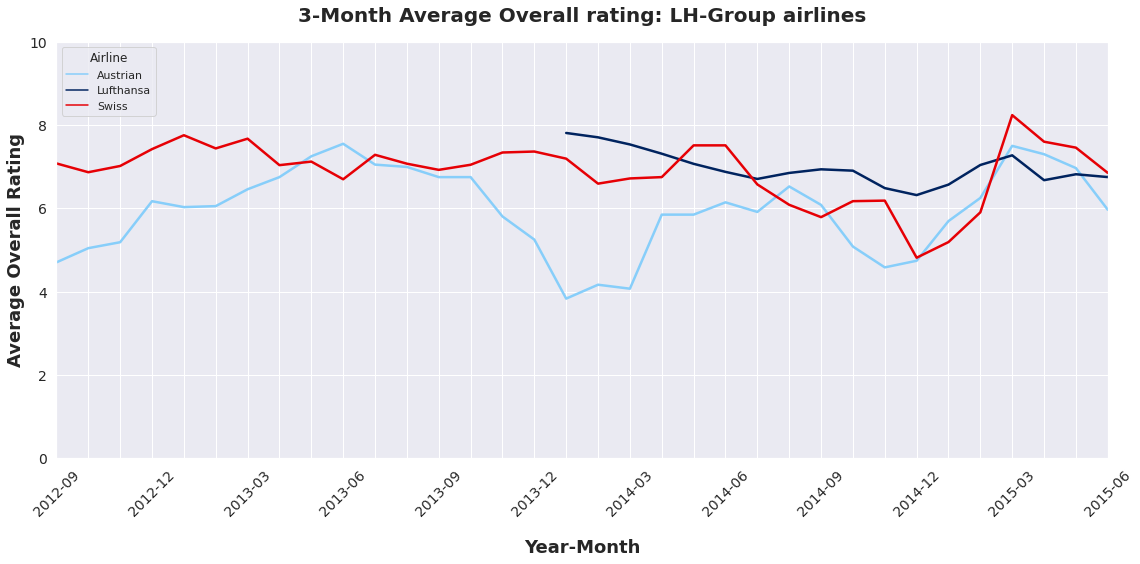

In [38]:
rollingFig, rollingAx = plt.subplots(1,1, figsize=(16,8))

rollingAx = sns.lineplot(x="date", y="overall_rating", hue="Airline", palette=groupPalette, data=rollingMean, lw=2.5)

rollingAx.tick_params(axis='x', rotation=45)


rollingAx.set_xlabel('Year-Month', fontsize=18, fontweight='bold', labelpad=20)
rollingAx.set_ylabel('Average Overall Rating', fontsize=18, fontweight='bold')
rollingAx.set_title('3-Month Average Overall rating: LH-Group airlines',fontsize=20, fontweight='bold', pad=20)

rollingAx.tick_params(axis='both', which='major', labelsize=14)

rollingAx.set_xlim(xticks[4],xticks[-5])

#rollingAx.set_xlim('2012-08','2015-06')
rollingAx.set_ylim(0, 10)

# kann man über Locator und Formatter schöner lösen, aber tut hier seinen Zweck
for index, label in enumerate(rollingAx.xaxis.get_ticklabels()):
    if (index+2) % 3 != 0:
        label.set_visible(False)
        
rollingFig.tight_layout()

In [39]:

#len(contentData['austrian-airlines'])

In [40]:
datapointMean = reviewTimeline.drop(columns={'cabin_flown'})
datapointMean = datapointMean.set_index(['Airline','date'])
datapointMean.head()

overall_rating  seat_comfort_rating  cabin_staff_rating  \
Airline date                                                               
Swiss   2015-07             9.0                  5.0                 5.0   
        2015-07             9.0                  4.0                 5.0   
        2015-07             8.0                  5.0                 4.0   
        2015-07             7.0                  4.0                 4.0   
        2015-07             1.0                  1.0                 1.0   

                 food_beverages_rating  inflight_entertainment_rating  \
Airline date                                                            
Swiss   2015-07                    5.0                            4.0   
        2015-07                    5.0                            3.0   
        2015-07                    4.0                            4.0   
        2015-07                    4.0                            3.0   
        2015-07                    1.0                            1.0   

                 value_money_rating  recommended  
Airline date                                      
Swiss   2015-07                 5.0            1  
        2015-07                 5.0            1  
        2015-07                 5.0            1  
        2015-07                 4.0            1  
        2015-07                 1.0            0

In [41]:
datapointMean = reviewTimeline.drop(columns={'cabin_flown'})

#datapointMean = datapointMean.set_index(['Airline','date'])#['overall_rating'].mean()#.mean()#.mean()
#datapointMean = datapointMean.rolling(20).mean()

overallMean = datapointMean.groupby(['Airline'])['overall_rating'].rolling(3).mean()#.reset_index(0,drop=True)#.reset_index()#,'date'])
#datapointMean['rolling_overall'] = datapointMean['overall_rating'].rolling(3).mean()
#monthlyMean = monthlyMean.reset_index() #= rollingMean.groupby(['Airline','date']).rolling(3,1).mean()#rolling(window=3)['overall_rating'].mean()
#rollingMean = monthlyMean.groupby(['Airline']).rolling(3,1, on='date').mean()
#datapointMean.head()
datapointMean.reset_index().index

RangeIndex(start=0, stop=1213, step=1)

In [42]:
#overallMean.reset_index().index
datapointMean = reviewTimeline.drop(columns={'cabin_flown'})
date = datapointMean.groupby(['Airline'])
#datapointMean = datapointMean.drop(columns={'date'})


ast = datapointMean.groupby(['Airline']).rolling(3).mean(numeric_only=True)
#ast = datapointMean.set_index(['Airline'])
#bst = datapointMean.groupby(['Airline'])
#date = datapointMean.groupby(['Airline'])['date']
#datapointMean = datapointMean.drop(columns='date')
date

/tmp/ipykernel_10109/1600522206.py:7: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  ast = datapointMean.groupby(['Airline']).rolling(3).mean(numeric_only=True)


In [43]:
#test = reviewTimeline[reviewTimeline['Airline']=='Swiss']
#test[test['date']=='2015-03']
#pd.set_option('display.max_rows', None)
#rollingMean.loc['2014-10':]
#pd.set_option('display.max_rows', 20)
testSet = groupSet.copy(deep=True)
testSet['date'] = pd.to_datetime(testSet['date'])

testSet = testSet.drop(columns={'cabin_flown'})
ast = testSet.set_index('date')#.rolling(3).mean()
ast = ast.groupby(['Airline']).rolling(2).mean()
ast = ast.reset_index()
ast['date'] = ast['date'].dt.strftime('%Y-%m')
#ast = ast.groupby(['Airline'])

In [44]:
testSet = groupSet.copy(deep=True)
testSet['date'] = pd.to_datetime(testSet['date'])

testSet = testSet.drop(columns={'cabin_flown'})
ast = testSet.set_index('date')#.rolling(3).mean()
ast = ast.groupby(['Airline']).rolling(20,1).mean()
ast = ast.reset_index()
ast = ast.sort_values(by='date')
ast['date'] = ast['date'].dt.strftime('%Y-%m')
#ast['date'] = ast['date'].dt.strftime('%Y-%m')
#ast = ast.groupby(['Airline'])

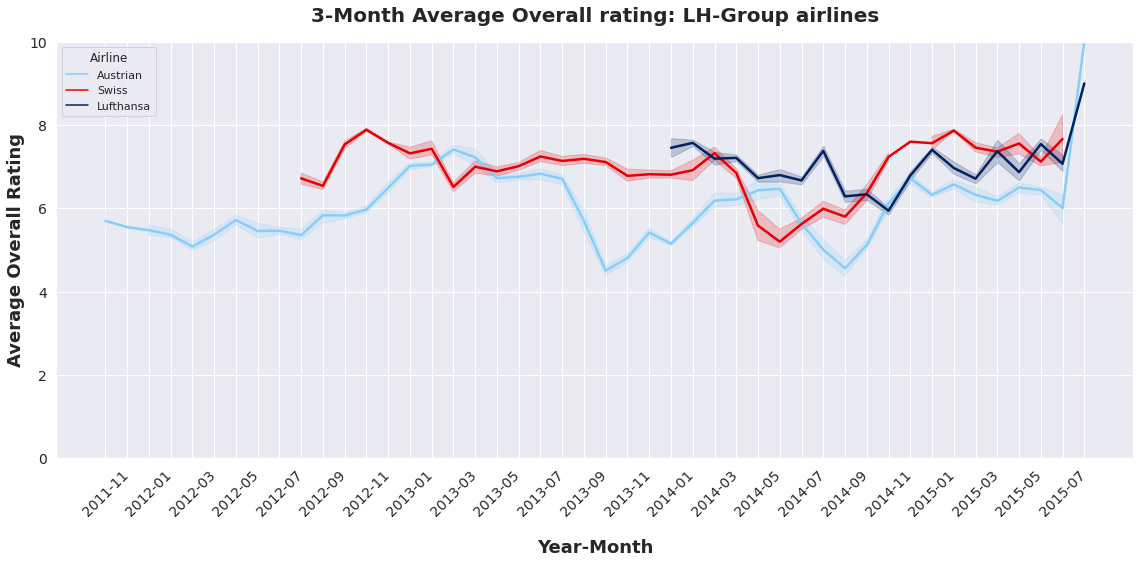

In [45]:
rollingFig, rollingAx = plt.subplots(1,1, figsize=(16,8))

rollingAx = sns.lineplot(x="date", y="overall_rating", hue="Airline", palette=groupPalette, data=ast, lw=2.5)

xticks = ast.index.get_level_values(0)


#date_form = DateFormatter('%Y-%M')
rollingAx.tick_params(axis='x', rotation=45)


rollingAx.set_xlabel('Year-Month', fontsize=18, fontweight='bold', labelpad=20)
rollingAx.set_ylabel('Average Overall Rating', fontsize=18, fontweight='bold')
rollingAx.set_title('3-Month Average Overall rating: LH-Group airlines',fontsize=20, fontweight='bold', pad=20)

rollingAx.tick_params(axis='both', which='major', labelsize=14)

#rollingAx.set_xlim(xticks[0],xticks[-1])
rollingAx.set_ylim(0, 10)

# kann man über Locator und Formatter schöner lösen, aber tut hier seinen Zweck
for index, label in enumerate(rollingAx.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
rollingFig.tight_layout()

In [46]:
test = reviewTimeline[reviewTimeline['Airline']=='Lufthansa']
test[test['date']=='2015-02'].mean()

/tmp/ipykernel_10109/1487439729.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test[test['date']=='2015-02'].mean()


overall_rating                   7.461538
seat_comfort_rating              3.153846
cabin_staff_rating               4.461538
food_beverages_rating            3.692308
inflight_entertainment_rating    3.923077
value_money_rating               3.923077
recommended                      0.923077
dtype: float64

In [47]:
## Create data set and color palette for LH-group
#
#groupPalette = {'Lufthansa' : lufthansaBlue, 'Swiss' : swissRed, 'Austrian' : austrianBlue}
#
#groupSet = pd.concat([lhGroup['swiss'], lhGroup['lufthansa'], lhGroup['austrian']])
#groupSet.replace(to_replace={'Airline' : 'swiss-international-air-lines'}, value='Swiss', inplace=True)
#groupSet.replace(to_replace={'Airline' : 'austrian-airlines'}, value='Austrian', inplace=True)
#groupSet.replace(to_replace={'Afirline' : 'lufthansa'}, value='Lufthansa', inplace=True)
#
## Create data set and color palette for 5-Star airlines
#
#fiveStarPalette = {'Swiss' : swissRed, 'Singapore' : siaOrange,
#                   'Cathay' : cathayGreen, 'Qatar' : qatarGrey, 'Garuda' : garudaBlue}
#
#fiveStarSet = pd.concat([lhGroup['swiss'], fiveStar['sia'],
#                     fiveStar['cathay'], fiveStar['qatar'], fiveStar['garuda']])
#
#fiveStarSet.replace(to_replace={'Airline' : 'singapore-airlines'}, value='Singapore', inplace=True)
#fiveStarSet.replace(to_replace={'Airline' : 'cathay-pacific-airways'}, value='Cathay', inplace=True)
#fiveStarSet.replace(to_replace={'Airline' : 'qatar-airways'}, value='Qatar', inplace=True)
#fiveStarSet.replace(to_replace={'Airline' : 'swiss-international-air-lines'}, value='Swiss', inplace=True)
#fiveStarSet.replace(to_replace={'Airline' : 'garuda-indonesia'}, value='Garuda', inplace=True)
#
## Create data set and color palette for 5-Star airlines
#
#legacyPalette = {'Swiss' : swissRed, 'American' : americanGray, 'United' : unitedBlue, 'Delta' : deltaBlue}
#
#legacySet = pd.concat([lhGroup['swiss'], legacyCarrier['united'],
#                     legacyCarrier['delta'], legacyCarrier['american']])
#
#legacySet.replace(to_replace={'Airline' : 'united-airlines'}, value='United', inplace=True)
#legacySet.replace(to_replace={'Airline' : 'delta-air-lines'}, value='Delta', inplace=True)
#legacySet.replace(to_replace={'Airline' : 'american-airlines'}, value='American', inplace=True)
#legacySet.replace(to_replace={'Airline' : 'swiss-international-air-lines'}, value='Swiss', inplace=True)
#
## Create data set and color palette for european competitors
#
#europePalette = {'Swiss' : swissRed, 'AirFrance' : afRed, 'KLM' : klmBlue, 'British' : britishBlue}
#
#europeSet = pd.concat([lhGroup['swiss'], europe['airfrance'],
#                     europe['klm'], europe['british']])
#
#europeSet.replace(to_replace={'Airline' : 'klm-royal-dutch-airlines'}, value='KLM', inplace=True)
#europeSet.replace(to_replace={'Airline' : 'air-france'}, value='AirFrance', inplace=True)
#europeSet.replace(to_replace={'Airline' : 'british-airways'}, value='British', inplace=True)
#europeSet.replace(to_replace={'Airline' : 'swiss-international-air-lines'}, value='Swiss', inplace=True)

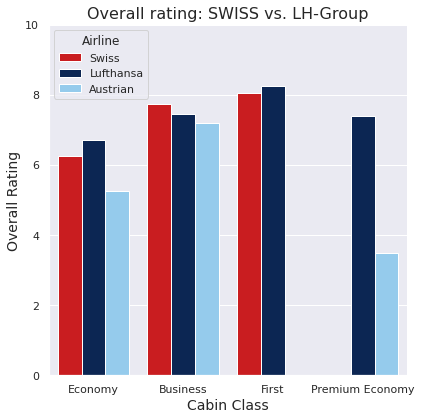

In [48]:
g = sns.catplotg = sns.catplot(
    data=groupSet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="Airline", palette=groupPalette,
    height=6, ci=None, legend_out=False
)
g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Overall Rating', fontsize=14)
g.ax.set_title('Overall rating: SWISS vs. LH-Group',fontsize=16)
g.ax.set_ylim(0,10)
g.fig.tight_layout()

(0.0, 10.0)

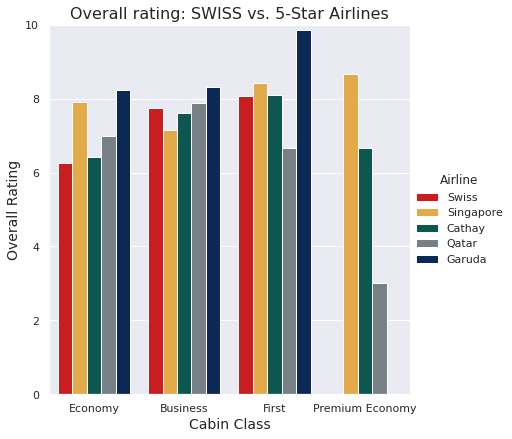

In [49]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Overall Rating', fontsize=14)
g.ax.set_title('Overall rating: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,10)
#g.fig.tight_layout()

(0.0, 10.0)

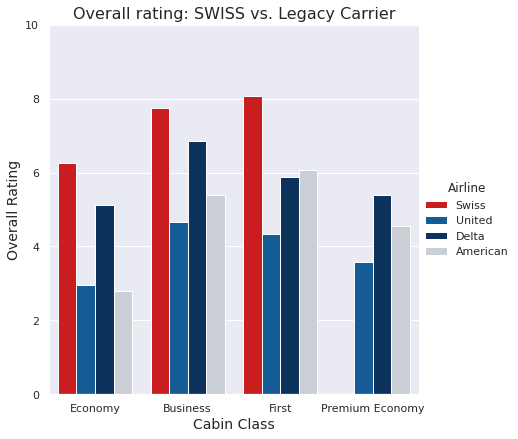

In [50]:
g = sns.catplot(
    data=legacySet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="Airline", palette=legacyPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Overall Rating', fontsize=14)
g.ax.set_title('Overall rating: SWISS vs. Legacy Carrier',fontsize=16)
g.ax.set_ylim(0,10)
#g.fig.tight_layout()

(0.0, 10.0)

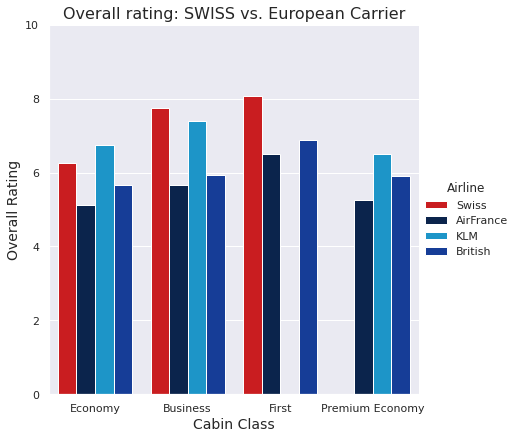

In [51]:
g = sns.catplot(
    data=europeSet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="Airline", palette=europePalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Overall Rating', fontsize=14)
g.ax.set_title('Overall rating: SWISS vs. European Carrier',fontsize=16)
g.ax.set_ylim(0,10)
#g.fig.tight_layout()

In [52]:
# drop data for premium economy, as SWISS did not have a premium eco in 2015

fiveStarSet = fiveStarSet[fiveStarSet.cabin_flown != 'Premium Economy']

(0.0, 5.0)

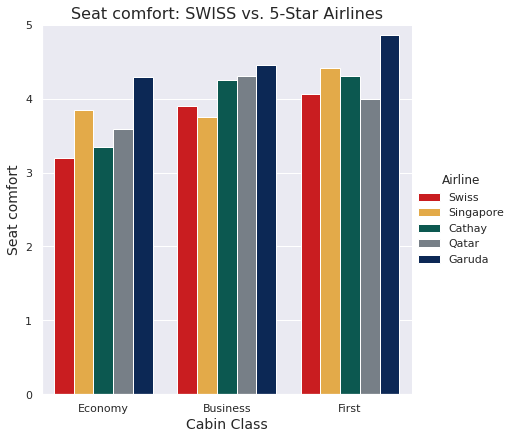

In [53]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="seat_comfort_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Seat comfort', fontsize=14)
g.ax.set_title('Seat comfort: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,5)
#g.fig.tight_layout()

(0.0, 5.0)

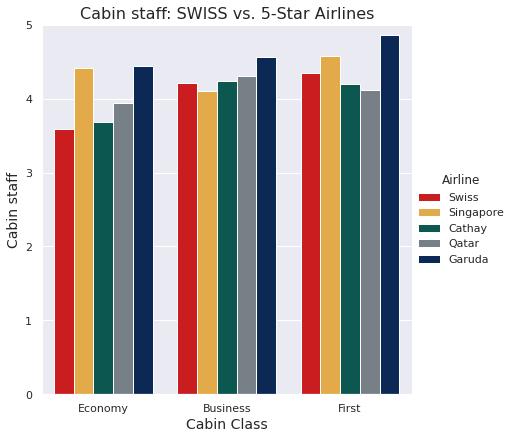

In [54]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="cabin_staff_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Cabin staff', fontsize=14)
g.ax.set_title('Cabin staff: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,5)
#g.fig.tight_layout()

(0.0, 5.0)

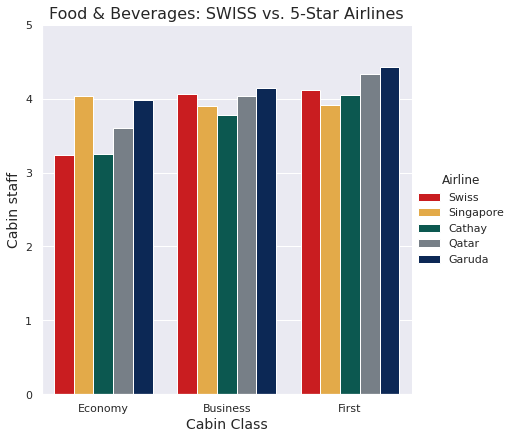

In [55]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="food_beverages_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Cabin staff', fontsize=14)
g.ax.set_title('Food & Beverages: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,5)
#g.fig.tight_layout()

(0.0, 5.0)

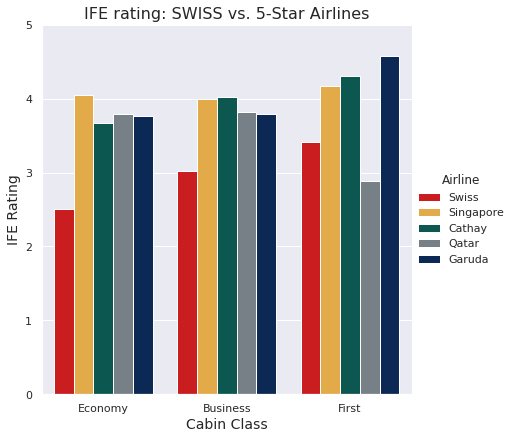

In [56]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="inflight_entertainment_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('IFE Rating', fontsize=14)
g.ax.set_title('IFE rating: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,5)
#g.fig.tight_layout()

(0.0, 5.0)

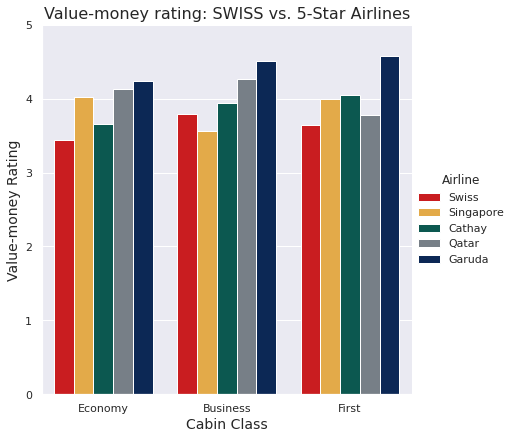

In [57]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="value_money_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Value-money Rating', fontsize=14)
g.ax.set_title('Value-money rating: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,5)
#g.fig.tight_layout()

<AxesSubplot:xlabel='cabin_flown', ylabel='overall_rating'>

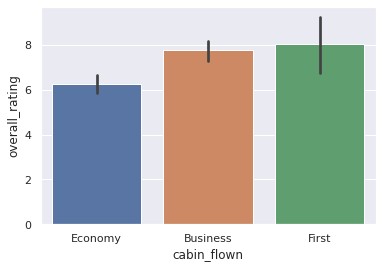

In [58]:
sns.barplot(data=lhGroup['swiss'], x="cabin_flown", y="overall_rating")

In [59]:
swiss = lhGroup['swiss']
sia = fiveStar['sia']
print(sia[sia['cabin_flown']=="Economy"]['overall_rating'].std())
print(swiss[swiss['cabin_flown']=="Economy"]['overall_rating'].std())

2.494266950547911
3.042318893644798


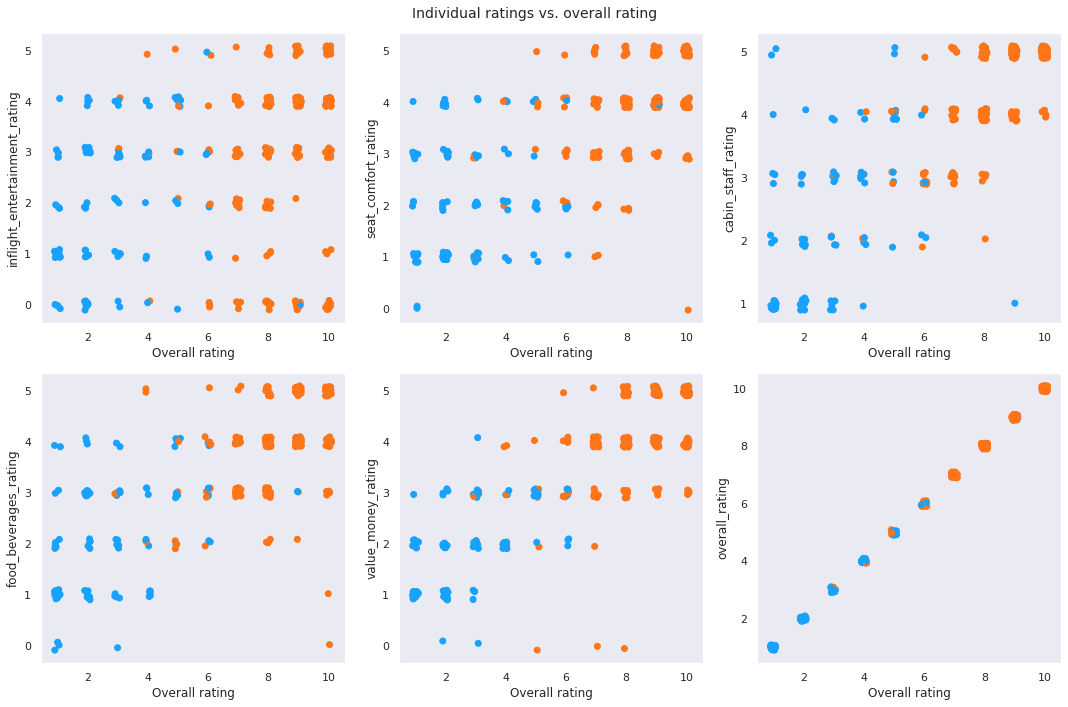

In [60]:
airline = lhGroup['swiss']

fig0, ax0 = plt.subplots(2,3, figsize=(15,10))
fig0.suptitle("Individual ratings vs. overall rating", fontsize=14)
colorMap = {0:neg, 1:pos}
#colorMap = {0:'r', 1:'k'}

xValue = airline['overall_rating']
yValue = [airline['inflight_entertainment_rating'], airline['seat_comfort_rating'], 
          airline['cabin_staff_rating'], airline['food_beverages_rating'],
          airline['value_money_rating'], airline['overall_rating']]

for i in range(2):
    for j in range(3):
        idx = 3*i + j
        
        jittered_y = xValue + 0.2 * np.random.rand(len(xValue)) -0.1
        jittered_x = yValue[idx] + 0.2 * np.random.rand(len(yValue[idx])) -0.1
        
        ax0[i][j].scatter(jittered_y, jittered_x, c=swiss['recommended'].map(colorMap))
        
        ax0[i][j].grid()
        ax0[i][j].set_xlabel("Overall rating")
        ax0[i][j].set_ylabel(yValue[idx].name)

fig0.tight_layout()

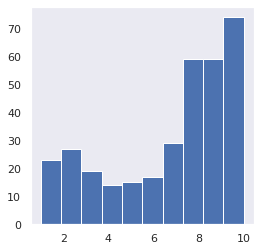

In [61]:
fig0, ax0 = plt.subplots(1,1, figsize=(4,4))

colorMap = {0: neg, 1: pos}

ax0.hist(swiss['overall_rating'])
ax0.grid()
#ax0.legend()

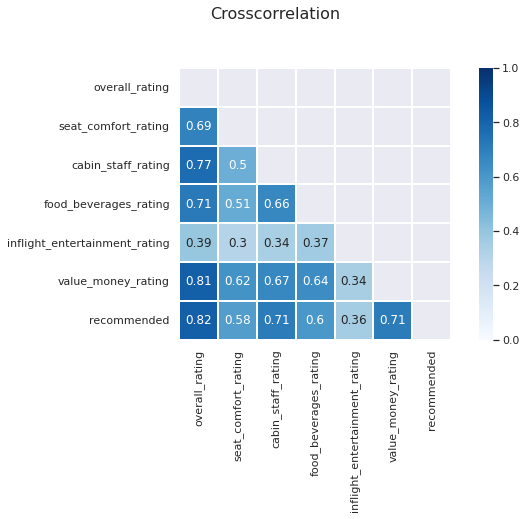

In [62]:
# Leitfrage: Welcher Faktor beeinflusst die Gesamtbewertung am meisten
df_corr = groupSet.corr()


colormap = plt.cm.Blues

fig17, ax17 = plt.subplots(figsize=(10,5))

fig17.suptitle(u'Crosscorrelation', y=1.05, size=16)

mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_corr, mask=mask, linewidths=0.1,vmin= 0, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [63]:
# Ideas: perform binary classification on recommendation

In [64]:
# Multivariate regression on overall rating

In [65]:
def get_airline_data(name):
    
    data = pd.read_csv('./data/airline.csv')
    airlineData = data[data["airline_name"] == name]
    print(f"Der Datensatz enthält {len(airlineData)} Datenpunkte")
    airlineData = airlineData.reset_index(drop=True)
    
    return airlineData